In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
import mdtraj
import io
import nglview

In [45]:
paper_dir = "/Users/noe/data/open_projects/boltzmann_generators/coarsegraining_KL/"

Alanine dipeptide
---

In [7]:
# Define coordinates
cart_indices = np.array([6, 8, 10, 14])  # N, Ca, C, Cb
ic_indices = np.array([[7, 6, 8, 14],
                       [9, 8, 6, 14],
                       [15, 14, 8, 6],
                       [11, 10, 8, 6],
                       [12, 10, 8, 11],
                       [13, 10, 8, 11],
                       [4, 6, 8, 14],
                       [1, 4, 6, 8],
                       [5, 4, 6, 1],
                       [3, 1, 4, 6],
                       [2, 1, 4, 3],
                       [0, 1, 4, 3],
                       [16, 14, 8, 6],
                       [18, 16, 14, 8],
                       [17, 16, 14, 18],
                       [19, 18, 16, 14],
                       [20, 18, 16, 19],
                       [21, 18, 16, 19]])

In [8]:
# Define coordinates
cart_indices2 = np.array([4, 6, 8, 10, 14, 16])  # N, Ca, C, Cb
ic_indices2 = np.array([[7, 6, 8, 14],
                       [9, 8, 6, 14],
                       [15, 14, 8, 6],
                       [11, 10, 8, 6],
                       [12, 10, 8, 11],
                       [13, 10, 8, 11],
                       #[4, 6, 8, 14],
                       [1, 4, 6, 8],
                       [5, 4, 6, 1],
                       [3, 1, 4, 6],
                       [2, 1, 4, 3],
                       [0, 1, 4, 3],
                       #[16, 14, 8, 15],
                       [18, 16, 14, 8],
                       [17, 16, 14, 18],
                       [19, 18, 16, 14],
                       [20, 18, 16, 19],
                       [21, 18, 16, 19]])

In [9]:
npzfile = np.load('/Users/noe/data/open_projects/md_data/AlaDi/AlaDi-1Mx1ps-with-force.npz')
xyz = npzfile['coordinates']

In [10]:
top = mdtraj.load('/Users/noe/data/open_projects/md_data/AlaDi/AlaDi.pdb').topology
traj = mdtraj.Trajectory(0.1*xyz, top)
traj.superpose(traj[0], atom_indices=cart_indices)

<mdtraj.Trajectory with 1000000 frames, 22 atoms, 3 residues, without unitcells at 0x1835e34f28>

In [11]:
view = nglview.show_mdtraj(traj[:1000])
view

NGLWidget(count=1000)

In [12]:
phi_indices, phi = mdtraj.compute_phi(traj)
psi_indices, psi = mdtraj.compute_psi(traj)
phi = phi[:, 0]
psi = psi[:, 0]

In [13]:
bins, xgrid, ygrid = np.histogram2d(phi, psi, bins=100, density=True)
xgrid = 0.5*(xgrid[1:] + xgrid[:-1])
ygrid = 0.5*(ygrid[1:] + ygrid[:-1])

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


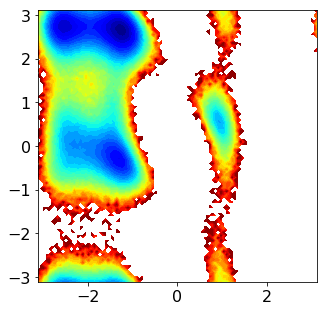

In [46]:
plt.figure(figsize=(5, 5))
plt.contourf(xgrid, ygrid, -np.log(bins.T), 40, cmap='jet')
plt.savefig(paper_dir + 'figs/ala2_phipsi_true.pdf')

In [15]:
for i, atom in enumerate(top.atoms):
    print(i, atom)

0 ACE1-H1
1 ACE1-CH3
2 ACE1-H2
3 ACE1-H3
4 ACE1-C
5 ACE1-O
6 ALA2-N
7 ALA2-H
8 ALA2-CA
9 ALA2-HA
10 ALA2-CB
11 ALA2-HB1
12 ALA2-HB2
13 ALA2-HB3
14 ALA2-C
15 ALA2-O
16 NME3-N
17 NME3-H
18 NME3-C
19 NME3-H1
20 NME3-H2
21 NME3-H3


Training
-------

In [16]:
batchsize_ML = 2048
temperature = 1.0
explore = 1.0

In [17]:
xyzflat = traj.xyz.reshape((traj.xyz.shape[0], -1))

In [18]:
#channels = np.tile([0, 0, 0, 1, 1, 1], 11)

In [30]:
bg = invnet(xyzflat.shape[1], 'RZRZRZRZRRZRR', energy_model=None,channels=None, 
            nl_layers=6, nl_hidden=[100, 100, 100, 100, 100], 
            nl_layers_scale=6, nl_hidden_scale=[100, 10, 10, 10, 100], 
            nl_activation='relu', nl_activation_scale='tanh', 
            ic=ic_indices2, ic_cart=cart_indices2, ic_norm=xyzflat)

I<RZRZRZRZRRZRR>
I 66 0 0
< 60 0 6
R 30 30 6
Z 30 30 6
R 15 15 36
Z 15 15 36
R 8 7 51
Z 8 7 51
R 4 4 58
Z 4 4 58
R 2 2 62
R 2 2 62
Z 2 2 62
R 1 1 64
R 1 1 64
> 1 1 64


In [64]:
# repeat this 4 times!
epochsZ = 2000
hist = bg.train_ML(xyzflat, lr=0.0001, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, 
                   verbose=0, return_test_energies=True)

(-320, -270)

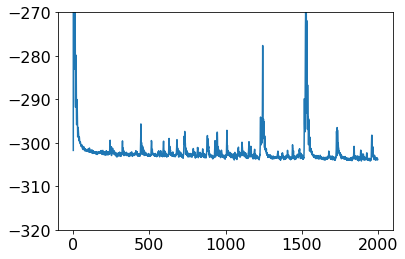

In [65]:
plt.plot(hist[0])
plt.plot(hist[1])
plt.ylim(-320, -270)

In [66]:
# sample
sample_z = np.random.randn(500000, xyzflat.shape[1])
sample_x = bg.transform_zx(sample_z)

In [67]:
traj_sample = mdtraj.Trajectory(sample_x.reshape((sample_x.shape[0], -1, 3)), top)

In [68]:
import nglview
view = nglview.show_mdtraj(traj_sample[:1000])
view

NGLWidget(count=1000)

In [69]:
_, phi_sample = mdtraj.compute_phi(traj_sample)
_, psi_sample = mdtraj.compute_psi(traj_sample)
phi_sample = phi_sample[:, 0]
psi_sample = psi_sample[:, 0]

In [70]:
bins_sample, xgrid, ygrid = np.histogram2d(phi_sample, psi_sample, bins=100, density=True)
xgrid = 0.5*(xgrid[1:] + xgrid[:-1])
ygrid = 0.5*(ygrid[1:] + ygrid[:-1])

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


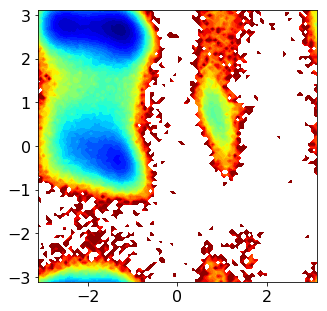

In [71]:
plt.figure(figsize=(5, 5))
plt.contourf(xgrid, ygrid, -np.log(bins_sample.T), 40, cmap='jet')

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


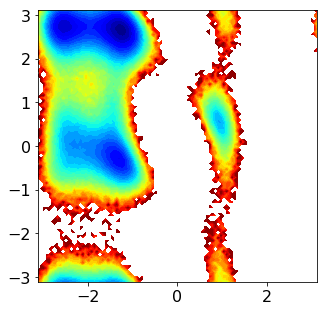

In [47]:
plt.figure(figsize=(5, 5))
plt.contourf(xgrid, ygrid, -np.log(bins.T), 40, cmap='jet')

In [81]:
torsion_indices = [[0, 1, 4, 6],
                   [1, 4, 6, 8],
                   [4, 6, 8, 14],
                   [6, 8, 10, 11],
                   [6, 8, 14, 16],
                   [8, 14, 16, 18],
                   [8, 14, 16, 18]]
torsions = mdtraj.compute_dihedrals(traj, torsion_indices)
torsions_sample = mdtraj.compute_dihedrals(traj_sample, torsion_indices)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


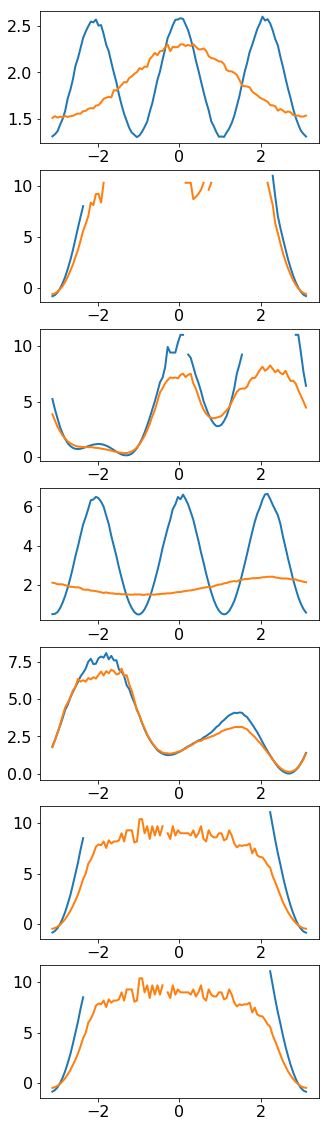

In [82]:
fig, axes = plt.subplots(nrows=len(torsion_indices), ncols=1, figsize=(5, 20))
for i in range(len(torsion_indices)):
    hist, bin_edges = np.histogram(torsions[:, i], bins=100, density=True)
    bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
    axes[i].plot(bin_values, -np.log(hist), linewidth=2)
    
    hist, bin_edges = np.histogram(torsions_sample[:, i], bins=100, density=True)
    bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
    axes[i].plot(bin_values, -np.log(hist), linewidth=2)

RG better order
-------

In [18]:
idx_cart = np.arange(0, 6)
idx_bond = np.arange(6, 60, 3)
idx_angle = np.arange(7, 60, 3)
idx_dih = np.arange(8, 60, 3)
flexible_torsions = np.array([3, 4, 5, 11, 13]) 
idx_dih_flex = 8 + 3*flexible_torsions
idx_dih_rigid = np.sort(np.array(list(set(list(idx_dih)) - set(list(idx_dih_flex)))))
idx_rest = np.arange(60, 66)
permute_order = np.concatenate([idx_dih_flex, idx_dih_rigid, idx_angle, idx_cart, idx_bond, idx_rest])

In [19]:
#bg_ic = invnet(xyzflat.shape[1], 'RZRZRZRZRRZRR', energy_model=None, channels=None, 
bg_ic = invnet(xyzflat.shape[1], 'PRZRRZRRZRRZRRRZRRR', energy_model=None, channels=None, permute_order=permute_order,
               nl_layers=6, nl_hidden=[100, 100, 100, 100, 100], 
               nl_layers_scale=6, nl_hidden_scale=[100, 10, 10, 10, 100], 
               nl_activation='relu', nl_activation_scale='tanh', 
               ic=ic_indices, ic_cart=cart_indices, ic_norm=xyzflat)

IP<RZRRZRRZRRZRRRZRRR>
I 66 0 0
P 60 0 6
< 60 0 6
R 30 30 6
Z 30 30 6
R 15 15 36
R 15 15 36
Z 15 15 36
R 8 7 51
R 8 7 51
Z 8 7 51
R 4 4 58
R 4 4 58
Z 4 4 58
R 2 2 62
R 2 2 62
R 2 2 62
Z 2 2 62
R 1 1 64
R 1 1 64
R 1 1 64
> 1 1 64
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [20]:
bg_ic.layers[0].Z_indices

array([[ 7,  6,  8, 14],
       [ 9,  8,  6, 14],
       [15, 14,  8,  6],
       [11, 10,  8,  6],
       [ 4,  6,  8, 14],
       [16, 14,  8,  6],
       [12, 10,  8, 11],
       [13, 10,  8, 11],
       [ 1,  4,  6,  8],
       [18, 16, 14,  8],
       [ 5,  4,  6,  1],
       [ 3,  1,  4,  6],
       [17, 16, 14, 18],
       [19, 18, 16, 14],
       [ 2,  1,  4,  3],
       [ 0,  1,  4,  3],
       [20, 18, 16, 19],
       [21, 18, 16, 19]])

In [21]:
bg_ic.layers[0].Z_indices[flexible_torsions]

array([[11, 10,  8,  6],
       [ 4,  6,  8, 14],
       [16, 14,  8,  6],
       [ 3,  1,  4,  6],
       [19, 18, 16, 14]])

In [34]:
# repeat this 4 times!
epochsZ = 2500
hists = []
for i in range(6):
    hist = bg_ic.train_ML(xyzflat, lr=0.0001, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, 
                          verbose=0, return_test_energies=True)
    hists.append(hist)

In [35]:
hist = bg_ic.train_ML(xyzflat, lr=0.0001, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, 
                      verbose=0, return_test_energies=True)
hists.append(hist)

(-320, -270)

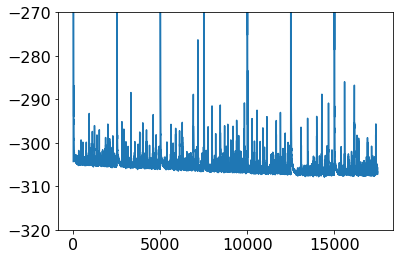

In [36]:
plt.plot(np.concatenate([h[0] for h in hists]))
plt.plot(np.concatenate([h[1] for h in hists]))
plt.ylim(-320, -270)

In [37]:
# sample
sample_z = np.random.randn(500000, xyzflat.shape[1])
sample_x = bg_ic.transform_zx(sample_z)

In [38]:
traj_sample = mdtraj.Trajectory(sample_x.reshape((sample_x.shape[0], -1, 3)), top)

In [39]:
import nglview
view = nglview.show_mdtraj(traj_sample[:1000])
view

NGLWidget(count=1000)

In [40]:
_, phi_sample = mdtraj.compute_phi(traj_sample)
_, psi_sample = mdtraj.compute_psi(traj_sample)
phi_sample = phi_sample[:, 0]
psi_sample = psi_sample[:, 0]

In [41]:
bins_sample, xgrid, ygrid = np.histogram2d(phi_sample, psi_sample, bins=100, density=True)
xgrid = 0.5*(xgrid[1:] + xgrid[:-1])
ygrid = 0.5*(ygrid[1:] + ygrid[:-1])

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


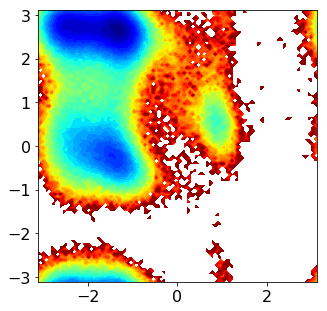

In [47]:
plt.figure(figsize=(5, 5))
plt.contourf(xgrid, ygrid, -np.log(bins_sample.T), 40, cmap='jet')
plt.savefig(paper_dir + 'figs/ala2_phipsi_IC.pdf')

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


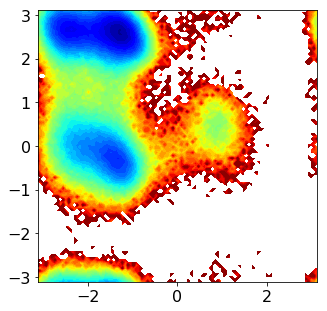

In [38]:
plt.figure(figsize=(5, 5))
plt.contourf(xgrid, ygrid, -np.log(bins_sample.T), 40, cmap='jet')

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


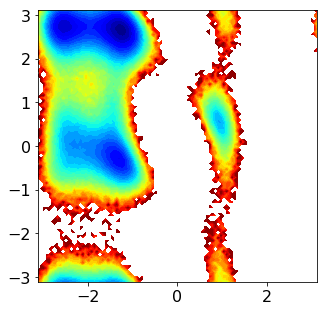

In [28]:
plt.figure(figsize=(5, 5))
plt.contourf(xgrid, ygrid, -np.log(bins.T), 40, cmap='jet')

In [43]:
torsion_indices = [[11, 10,  8,  6],
                   [ 4,  6,  8, 14],
                   [16, 14,  8,  6],
                   [ 3,  1,  4,  6],
                   [19, 18, 16, 14]]
torsions = mdtraj.compute_dihedrals(traj, torsion_indices)
torsions_sample = mdtraj.compute_dihedrals(traj_sample, torsion_indices)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


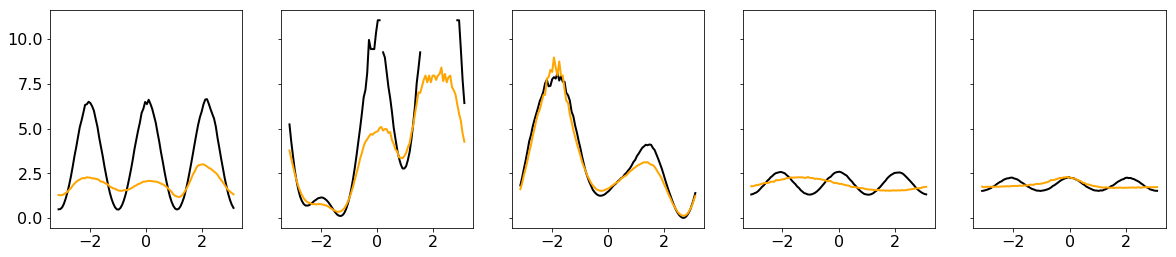

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=len(torsion_indices), figsize=(20, 4), sharey=True)
for i in range(len(torsion_indices)):
    hist, bin_edges = np.histogram(torsions[:, i], bins=100, density=True)
    bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
    axes[i].plot(bin_values, -np.log(hist), linewidth=2, color='black')
    
    hist, bin_edges = np.histogram(torsions_sample[:, i], bins=100, density=True)
    bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
    axes[i].plot(bin_values, -np.log(hist), linewidth=2, color='orange')
plt.savefig(paper_dir + 'figs/ala2_torsions.pdf')

More Cartesian
----

In [84]:
channels = np.tile([0, 0, 0, 1, 1, 1], 11)
bg_cart = invnet(xyzflat.shape[1], 'RZRZRZRZRRRR', energy_model=None, channels=channels, 
                 nl_layers=6, nl_hidden=[100, 100, 100, 100, 100], 
                 nl_layers_scale=6, nl_hidden_scale=[100, 10, 10, 10, 100], 
                 nl_activation='relu', nl_activation_scale='tanh')

<RZRZRZRZRRRR>
< 66 0 0
R 33 33 0
Z 33 33 0
R 18 15 33
Z 18 15 33
R 9 8 49
Z 9 8 49
R 6 3 57
Z 6 3 57
R 3 2 61
R 3 2 61
R 3 2 61
R 3 2 61
> 3 2 61


In [159]:
# repeat this 4 times!
epochsZ = 2000
hist = bg_cart.train_ML(xyzflat, lr=0.0001, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, 
                        verbose=0, return_test_energies=True)

(-300, -200)

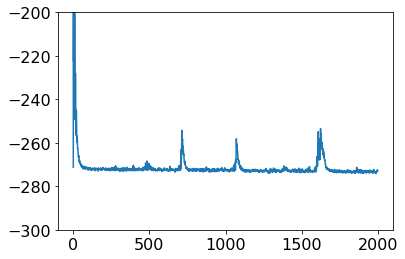

In [160]:
plt.plot(hist[0])
plt.plot(hist[1])
plt.ylim(-300, -200)

In [161]:
# sample
sample_z = np.random.randn(500000, xyzflat.shape[1])
sample_x = bg_cart.transform_zx(sample_z)

In [162]:
traj_sample = mdtraj.Trajectory(sample_x.reshape((sample_x.shape[0], -1, 3)), top)

In [163]:
import nglview
view = nglview.show_mdtraj(traj_sample[:1000])
view

NGLWidget(count=1000)

In [164]:
_, phi_sample = mdtraj.compute_phi(traj_sample)
_, psi_sample = mdtraj.compute_psi(traj_sample)
phi_sample = phi_sample[:, 0]
psi_sample = psi_sample[:, 0]

In [165]:
bins_sample, xgrid, ygrid = np.histogram2d(phi_sample, psi_sample, bins=100, density=True)
xgrid = 0.5*(xgrid[1:] + xgrid[:-1])
ygrid = 0.5*(ygrid[1:] + ygrid[:-1])

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


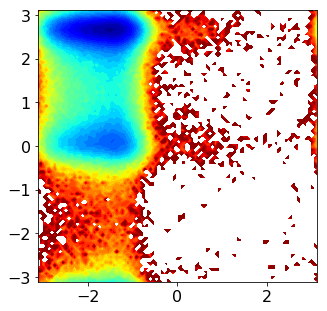

In [166]:
plt.figure(figsize=(5, 5))
plt.contourf(xgrid, ygrid, -np.log(bins_sample.T), 40, cmap='jet')

In [167]:
torsion_indices = [[0, 1, 4, 6],
                   [1, 4, 6, 8],
                   [4, 6, 8, 14],
                   [6, 8, 10, 11],
                   [6, 8, 14, 16],
                   [8, 14, 16, 18],
                   [8, 14, 16, 18]]
torsions = mdtraj.compute_dihedrals(traj, torsion_indices)
torsions_sample = mdtraj.compute_dihedrals(traj_sample, torsion_indices)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


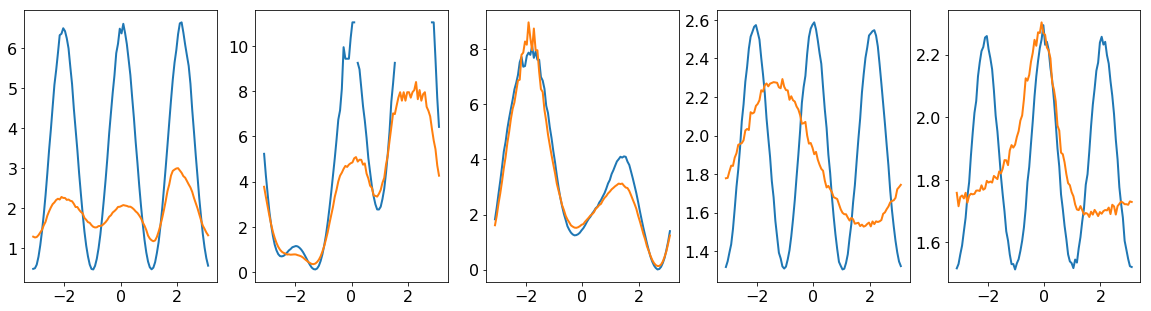

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=len(torsion_indices), figsize=(20, 5))
for i in range(len(torsion_indices)):
    hist, bin_edges = np.histogram(torsions[:, i], bins=100, density=True)
    bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
    axes[i].plot(bin_values, -np.log(hist), linewidth=2)
    
    hist, bin_edges = np.histogram(torsions_sample[:, i], bins=100, density=True)
    bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
    axes[i].plot(bin_values, -np.log(hist), linewidth=2)